# 1.0 Import required libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/kavan33_gmail_com/fastai/envv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from sklearn.metrics import f1_score, confusion_matrix

In [4]:
torch.cuda.set_device(0)

In [87]:
PATH = "/home/kavan33_gmail_com/fastai/data/"
sz = 224
arch = resnet50
bs = 32

In [6]:
label = pd.read_csv(f'{PATH}/data/TrainData/labels.csv')

In [7]:
label2 = label[:100000]

In [8]:
#label2.to_csv(f'{PATH}/data/TrainData/labels2.csv',index=False)

In [9]:
#l0 = label[label['label_id']==0][:55000]
#l1 = label[label['label_id']==1]
#l2 = label[label['label_id']==2]
#l3 = label[label['label_id']==3][:55000]
#label_truncated = pd.concat([l0,l1,l2,l3],axis=0)

In [10]:
#label_truncated.to_csv(f'{PATH}/data/TrainData/label.csv',index=False)

In [8]:
label_csv = f'{PATH}/data/TrainData/labels2.csv' #CHANGE THIS ACCORDING TO NEED
n = len(list(open(label_csv))) - 1  
val_idxs = get_cv_idxs(n) 

In [9]:
label.head()

,image_id,label_id
0,396612,0
1,286612,3
2,421709,3
3,90089,0
4,296118,3


In [13]:
n

100000

In [11]:
len(val_idxs)

20000

# 2.0 Visualization

In [30]:
train_info = pd.read_csv('/home/kavan33_gmail_com/BATCH/info.csv')

In [75]:
def display_image(label,info):
    f, ax = plt.subplots(2,2)
    f.suptitle("Label id:{}, Label text : {}".format(label,train_info[train_info['label_id']==label]['label_text'].iloc[0]))
    ax[0,0].imshow(Image.open(train_info[train_info['label_id']==label]['image_path'].iloc[0]))
    ax[0,1].imshow(Image.open(train_info[train_info['label_id']==label]['image_path'].iloc[1]))
    ax[1,0].imshow(Image.open(train_info[train_info['label_id']==label]['image_path'].iloc[2]))
    ax[1,1].imshow(Image.open(train_info[train_info['label_id']==label]['image_path'].iloc[3]))

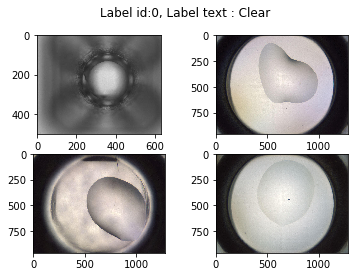

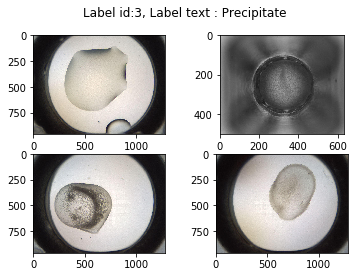

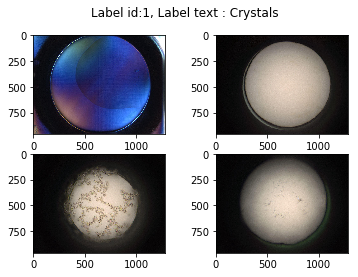

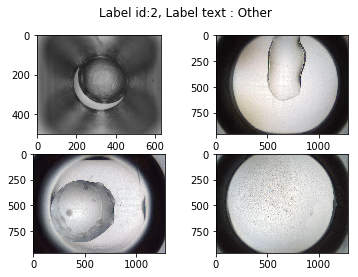

In [76]:
for i in train_info['label_id'].unique():
    display_image(i,train_info)

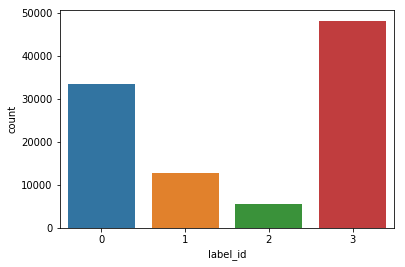

In [77]:
label_count = pd.DataFrame(label2.groupby(['label_id'])['label_id'].count())
label_count.columns = ['count']
label_count.reset_index(inplace=True)
sns.barplot(label_count['label_id'],label_count['count'])

#### Images of Class 2 are comparatively less than other classes, which might be a difficulty in learning the image.

In [78]:
from sklearn.manifold import TSNE
import cv2

In [79]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X = []
label =[]
for i in range(len(train_info)):
    row = train_info.iloc[i]
    img = row['image_path']
    lab = row['label_id']
    img = cv2.imread(img)
    img.resize(224,224)
    img = img.flatten()
    X.append(img)
    label.append(lab)

In [80]:
tr = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1024 samples in 1.811s...
[t-SNE] Computed neighbors for 1024 samples in 83.298s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1024
[t-SNE] Computed conditional probabilities for sample 1024 / 1024
[t-SNE] Mean sigma: 843.578909
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.998493
[t-SNE] Error after 300 iterations: 0.642505


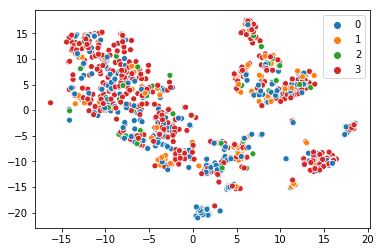

In [81]:
x = tr[:,0]
y = tr[:,1]
a = sns.scatterplot(x,y,hue=label,palette=sns.color_palette()[:4])

Looks like there is not much of information that can be derived from a dimensional reduction process.

In [36]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'TrainData', label_csv,val_idxs=val_idxs,test_name ='Test', suffix='.jpeg', tfms=tfms, bs=bs)

In [88]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'TrainData', label_csv, test_name ='Test',val_idxs=val_idxs, suffix='.jpeg', tfms=tfms, bs=bs)
    return data #if sz > 300 else data.resize(340, 'tmp')

In [ ]:
data = get_data(sz, bs)

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

 75%|███████▌  | 1883/2500 [01:00<00:22, 27.96it/s, loss=2.42] 

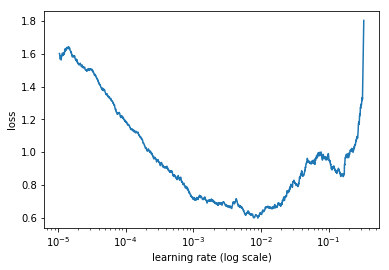

 75%|███████▌  | 1883/2500 [01:20<00:22, 27.96it/s, loss=2.42]

In [14]:
lrf = learn.lr_find()
learn.sched.plot()

In [15]:
learn.fit(1e-1, 10) 

epoch      trn_loss   val_loss   accuracy                      
    0      0.5406     0.464636   0.8294    
    1      0.535329   0.470673   0.8356                        
    2      0.555364   0.472698   0.8331                        
    3      0.518351   0.46131    0.83765                       
    4      0.505555   0.557891   0.81675                       
    5      0.475253   0.413035   0.8511                        
    6      0.528624   0.449568   0.83175                       
    7      0.519025   0.410956   0.85525                       
    8      0.515918   0.420794   0.85665                       
    9      0.500344   0.405896   0.8582                        


[array([0.4059]), 0.8582]

Looks like model got saturated after reaching accruacy of 85%

# 3.0 Making Predictions

## 3.1 Making predictions with TTA

In [52]:
def predict_TTA(learn):
    log_pred, y = learn.TTA()
    probs = np.mean(np.exp(log_pred),0)
    preds = np.argmax(probs,axis=1)
    return probs,y, preds

In [ ]:
probs, y, preds = predict_TTA(learn)

In [50]:
accuracy_np(probs,y)

0.86925

In [51]:
#preds = np.argmax(probs,axis=1)

In [52]:
f1_score(y,preds,average='micro')

0.86925

In [53]:
cm = confusion_matrix(y,preds)

[[6447   66   13  256]
 [ 157 1878   49  516]
 [ 134  101  499  382]
 [ 600  219  122 8561]]


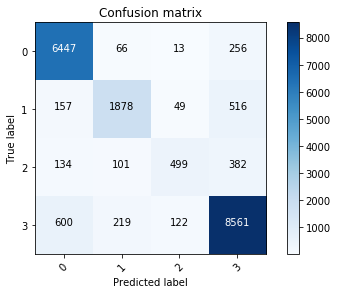

In [54]:
plot_confusion_matrix(cm, data.classes)

Looks like model is not able to learn Class 2 properly. i.e., Images of Class "Other"

In [16]:
learn.save("resnet")

In [38]:
learn.load("resnet")

## 3.2 Making predictions on Test data

In [41]:
temp = pd.read_csv("/home/kavan33_gmail_com/fastai/data/info.csv")

In [12]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)

In [44]:
test_info = pd.read_csv(f'{PATH}/data/info.csv')

In [ ]:
#fn = data.test_ds.fnames

In [16]:
#ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)

In [17]:
#dl = DataLoader(ds)

In [46]:
def predict_probs(learn):
    log_preds2, y2 = learn.TTA(is_test=True)
    probs = np.mean(np.exp(log_preds2),0)
    preds = np.argmax(probs,axis=1)
    preds = pd.DataFrame(preds)
    preds.columns = ['predicted_label']
    return y2, preds

In [ ]:
y2, preds2 = predict_probs(learn)

In [ ]:
preds2.headd()

In [28]:
type(fn)

list

In [53]:
def test_performance(data,predictions,test_info):
    fn = data.test_ds.fnames
    df = pd.Series( (v for v in fn) )
    df2 = pd.DataFrame(df.astype(str).str[5:-5])
    df2.columns = ['image_id']
    df2['predicted_label'] = predictions
    df2['image_id'] = pd.to_numeric(df2['image_id'])
    result = pd.merge(df2,test_info[['image_id','label_id']],how = 'inner',on='image_id')
    acc = sum(result['predicted_label']==result['label_id'])/len(result)
    c2 = confusion_matrix(result['label_id'],result['predicted_label'])
    return c2

In [66]:
cm = test_performance(fn,preds2, test_info)

In [67]:
cm

array([[15131,   174,    23,   330],
       [  461,  4704,   128,   907],
       [  380,   331,  1348,   751],
       [ 1884,  1012,   338, 19126]])

[[15131   174    23   330]
 [  461  4704   128   907]
 [  380   331  1348   751]
 [ 1884  1012   338 19126]]


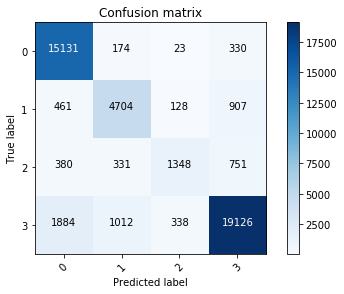

In [47]:
plot_confusion_matrix(cm,data.classes)

#### Class 2 images are most incorrectly classified, So we need to find a way to improve upon these images rather than fine tuning the network

In [68]:
print ("About ",round((cm[2][0]+cm[2][1]+cm[2][3])/(cm[2][0]+cm[2][1]+cm[2][3]+cm[2][2]),4)*100,"% misclassified images of Class 2")

About  52.03 % misclassified images of Class 2


# 4.0 UpSampling Class 2

In [15]:
label3 = pd.concat([label2,label2[label2['label_id']==2]])
label3 = pd.concat([label3,label2[label2['label_id']==2]])
label3 = label3.sample(frac=1).reset_index(drop=True)
label3.to_csv(f'{PATH}/data/TrainData/labels3.csv',index=False)

## 4.1 Visualization after Upsampling Class 2

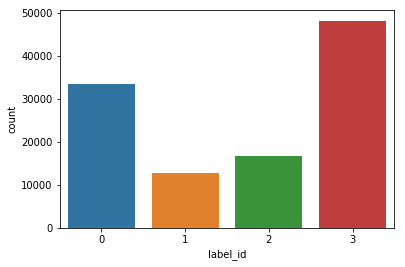

In [13]:
label_count = pd.DataFrame(label3.groupby(['label_id'])['label_id'].count())
label_count.columns = ['count']
label_count.reset_index(inplace=True)
sns.barplot(label_count['label_id'],label_count['count'])

In [16]:
label_csv = f'{PATH}/data/TrainData/labels3.csv' #CHANGE THIS ACCORDING TO NEED
n = len(list(open(label_csv))) - 1  
val_idxs = get_cv_idxs(n)

In [89]:
data2 = get_data(sz, bs)

In [90]:
learn2 = ConvLearner.pretrained(arch, data2, precompute=True)

100%|██████████| 625/625 [08:12<00:00,  1.15s/it]


 75%|███████▌  | 2088/2778 [01:43<00:36, 18.78it/s, loss=2.68] 

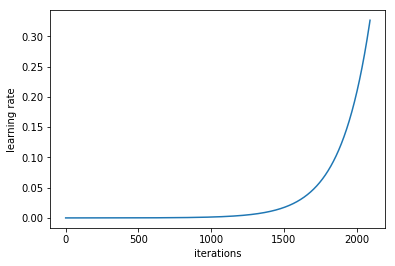

In [19]:
learn2.lr_find()
learn2.sched.plot_lr()

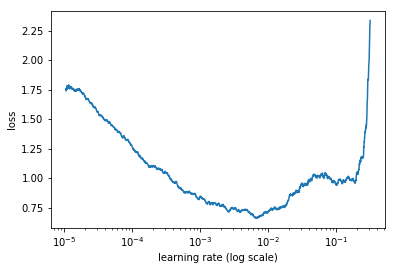

In [20]:
learn2.sched.plot()

In [22]:
lr2 = 0.05
learn2.fit(lr2, 10)

epoch      trn_loss   val_loss   accuracy                      
    0      0.60008    0.491578   0.816001  
    1      0.561454   0.460206   0.831526                      
    2      0.521651   0.444618   0.836206                      
    3      0.537796   0.432732   0.839401                      
    4      0.513228   0.424018   0.843855                      
    5      0.54653    0.472048   0.821176                      
    6      0.489336   0.405261   0.84948                       
    7      0.496755   0.402527   0.85398                       
    8      0.505143   0.394298   0.856725                      
    9      0.481289   0.436693   0.834946                      


[array([0.43669]), 0.8349457768978086]

Nosignificant improvement with upsampling the data, the model gets saturated after reaching around 85% accuracy.

In [23]:
learn2.save("resnet_upsample")

In [20]:
learn2.load("resnet_upsample")

## 4.2 Trying Adam with upsampling

In [20]:
learn2.opt_fn = optim.Adam

 62%|██████▏   | 1713/2778 [00:25<00:14, 73.25it/s, loss=1.65] 

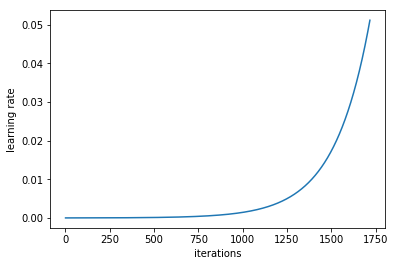

 62%|██████▏   | 1713/2778 [00:36<00:14, 73.25it/s, loss=1.65]

In [23]:
learn2.lr_find()
learn2.sched.plot_lr()

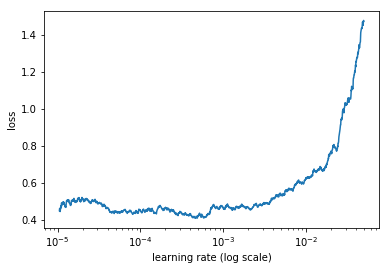

In [24]:
learn2.sched.plot()

In [43]:
lr2 = 0.001
learn2.fit(lr2, 10)

epoch      trn_loss   val_loss   accuracy                      
    0      0.451956   0.38557    0.859245  
    1      0.405449   0.37765    0.862665                      
    2      0.425132   0.366137   0.868695                      
    3      0.422899   0.366836   0.86928                       
    4      0.397633   0.353459   0.873194                      
    5      0.41681    0.350977   0.874049                      
    6      0.36884    0.371592   0.876254                      
    7      0.370073   0.332276   0.882239                      
    8      0.394432   0.338871   0.879674                      
    9      0.378217   0.328087   0.885029                      


[array([0.32809]), 0.8850290239841605]

#### Using Adam and upsampling Class 2 has contributed a notable improvement in the model. Looks like we can proceed further if we upsample more data. But we will have to take care the model doesn't overfit.

In [79]:
learn2.save("resnet_upsample2")

In [19]:
learn2.load("resnet_upsample2")

### This is a great improvement over previous model, 88% accuracy

## 4.3 Performance of Adam model on Test Images

In [29]:
preds3 = predict_probs(learn2)

In [30]:
fn = data2.test_ds.fnames

In [35]:
cm2 = test_performance(fn,preds3,test_info) # fn = data2.test_ds.fnames

In [33]:
def plot_confusion_matrix2(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, figsize=None):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize: cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2)
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.6) # made colour bar smaller
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90) # rotated to fit all labels
    plt.yticks(tick_marks, classes)

    #if normalize: cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2)
    #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], 
                 horizontalalignment="center", 
                 verticalalignment='center', # center aligned
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

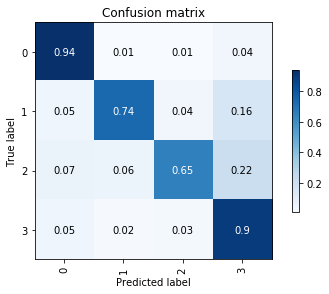

In [37]:
plot_confusion_matrix2(cm2,normalize=True, classes=data2.classes)

### About 65% of Class 2 images are predicted correctly!

# 5.0 Trying 1 -cycle learning rate policy

In [92]:
learn2.load("resnet_upsample2")

 72%|███████▏  | 1992/2778 [01:47<00:33, 23.38it/s, loss=1.23] 

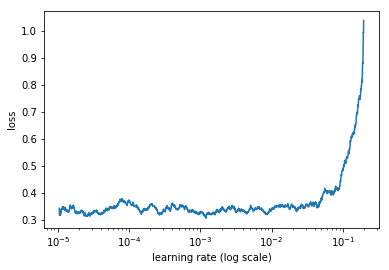

In [19]:
learn2.lr_find()
learn2.sched.plot()

In [26]:
lr = 0.05
learn2.fit(lr,n_cycle = 1, cycle_len= 5,use_clr_beta=(10,15,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                      
    0      0.383045   0.32821    0.882464  
    1      0.363471   0.356955   0.874454                       
    2      0.363076   0.335958   0.877379                       
    3      0.341085   0.319357   0.889664                       
    4      0.315503   0.306776   0.893084                       


[array([0.30678]), 0.8930837420690276]

In [93]:
lr = 0.05
learn2.fit(lr,n_cycle = 1, cycle_len= 10,use_clr_beta=(10,15,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                      
    0      0.365925   0.241972   0.91015   
    1      0.324519   0.239212   0.91095                       
    2      0.354874   0.228717   0.91565                       
    3      0.358329   0.263497   0.8997                        
    4      0.337318   0.245016   0.91025                       
    5      0.355522   0.229248   0.9212                        
    6      0.333577   0.22485    0.92025                       
    7      0.324919   0.223442   0.91705                       
    8      0.306446   0.214801   0.92485                       
    9      0.31575    0.214904   0.92315                       



[array([0.2149]), 0.92315]

In [94]:
learn2.save("resnet_1cycle")

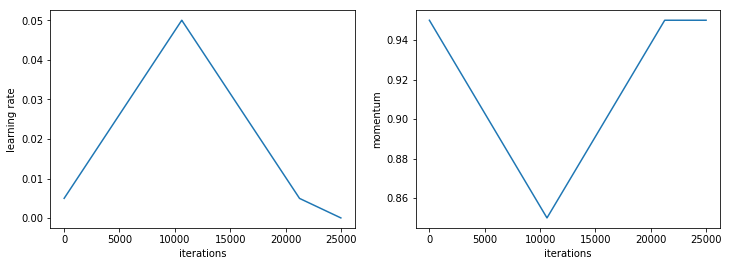

In [96]:
learn2.sched.plot_lr()

Still a good improvement!!

# 6.0 Fine tuning other layers of the model 

In [20]:
learn2.unfreeze()

In [21]:
lr = np.array([1e-3,1e-2,1e-1])

In [45]:
learn2.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                        
    0      0.486534   0.360463   0.872429  
    1      0.541125   0.390704   0.85875                         
    2      0.473418   0.356455   0.874949                        
    3      0.610264   0.42636    0.843135                        
 69%|██████▉   | 1928/2778 [29:48<07:52,  1.80it/s, loss=0.536]  

KeyboardInterrupt: 